In [1]:
ownerpath = f'/Users/lenfn/Documents/AST 443/AST 443 Group 5'

In [ ]:
#ownerpath = f'/content/drive/MyDrive/AST 443 Group 5'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np
import sep

import glob
import matplotlib.colors as colors
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.visualization import make_lupton_rgb
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
AstrometryNet.key = 'kwbavttkhitkoaeo'

%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from astropy.io import fits
from scipy.ndimage import shift

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Flats

In [3]:
#Open the flat field files and grab the data
raw_flats_120=[]

for i in range(5):
    flat_file=f'{ownerpath}/Lab 3/20tau/flats/flats_120s_.0000000{i}.FLAT.FIT'
    flat_file_data=fits.open(flat_file)
    raw_flats_120.append(flat_file_data[0].data)

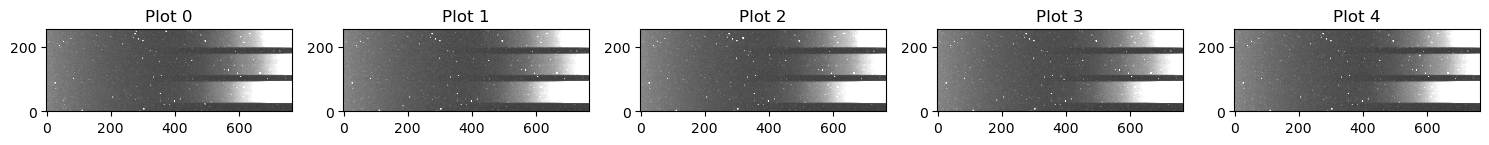

In [4]:
# All 5 Flat Fields
fig, axes = plt.subplots(1, 5, figsize=(15, 25))

# Loop over each subplot and display the images
for i in range(5):
    ax = axes[i]  # Select the appropriate axis
    ax.imshow(raw_flats_120[i],
              vmin=np.mean(raw_flats_120[i]) - np.std(raw_flats_120[i]),
              vmax=np.mean(raw_flats_120[i]) + np.std(raw_flats_120[i]),
              cmap='gray',
              origin='lower')
    ax.set_title(f"Plot {i}")
    #ax.axis('off')  # Optional: Hide axes for a cleaner look

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

# Master Flat Field

In [5]:
#Average the flat field frames to create the master flat field
master_flat = np.median(raw_flats_120, axis=0)

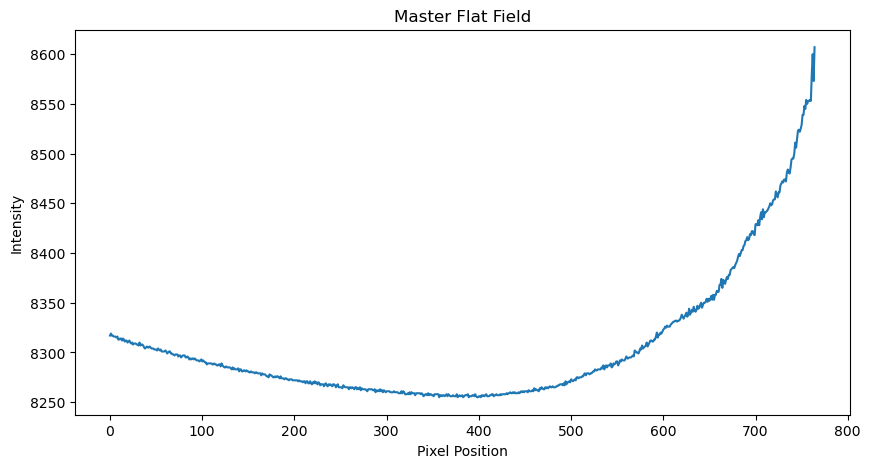

In [12]:
# Step 1: Sum along the y-axis for each mercury frame
master_flat_1d= np.median(master_flat, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(master_flat_1d)
plt.title("Master Flat Field")
plt.xlabel("Pixel Position")
plt.ylabel("Intensity")
plt.show()

# Dark

In [8]:
#Open the darks files and grab the data
raw_darks_120=[]

for i in range(5):
    dark_file=f'{ownerpath}/Lab 3/20tau/darks/darks_120s_.0000000{i}.DARK.FIT'
    dark_file_data=fits.open(dark_file)
    raw_darks_120.append(dark_file_data[0].data)

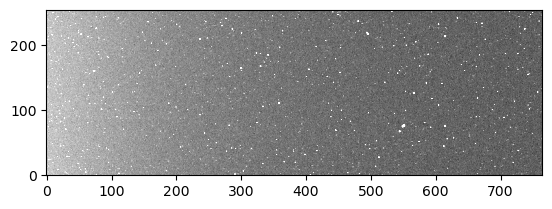

In [9]:
plt.imshow(raw_darks_120[2], vmin=np.mean(raw_darks_120[2])-np.std(raw_darks_120[2]),vmax=np.mean(raw_darks_120[2])+np.std(raw_darks_120[2]), cmap='gray', origin='lower')

# Master Dark Frame

In [10]:
#Average the dark frames to create the master dark
master_dark = np.median(raw_darks_120, axis=0)

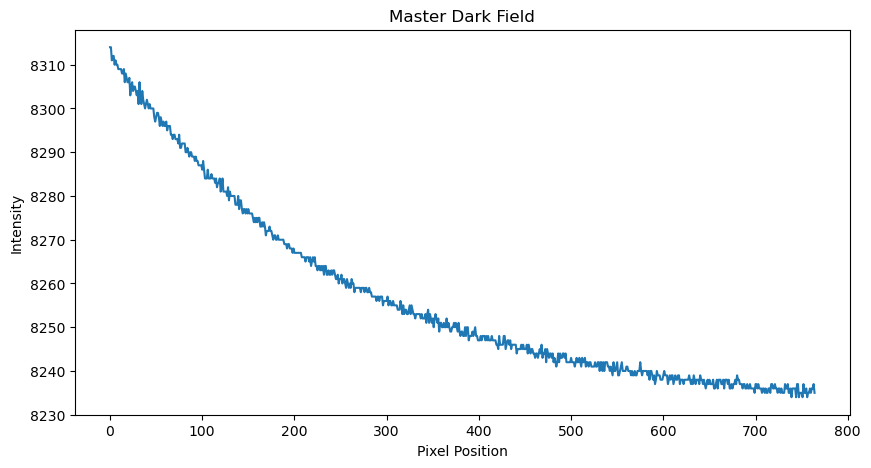

In [13]:
# Step 1: Sum along the y-axis for each mercury frame
master_dark_1d= np.median(master_dark, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(master_dark_1d)
plt.title("Master Dark Field")
plt.xlabel("Pixel Position")
plt.ylabel("Intensity")
plt.show()

# Making dark cuts for each star

In [14]:
# List to hold the cut data of each dark frame for 20tau
darks_20tau_cut = []

# Define the y-axis ranges for each frame
dark20_y_ranges = [(27, 63), (44, 80), (46, 82), (62, 98), (56, 92),
            (60, 96), (59, 95), (60, 96), (61, 97), (61, 97)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = dark20_y_ranges[i]
    cut_frame_data = master_dark[y_start:y_end, :]

    # Append the cut frame data to the list
    darks_20tau_cut.append(cut_frame_data)

In [23]:
# List to hold the cut data of each dark frame for etatau
darks_etatau_cut = []

# Define the y-axis ranges for each frame
y_ranges_eta = [(51, 71), (51, 71), (54, 74), (55, 75), (57, 77),
                (58, 78), (60, 80), (61, 81), (61, 81), (61, 81)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_eta[i]
    cut_frame_data = master_dark[y_start:y_end, :]

    # Append the cut frame data to the list
    darks_etatau_cut.append(cut_frame_data)

In [24]:
# List to hold the cut data of each dark frame for qtau
darks_qtau_cut = []

# Define the y-axis ranges for each frame
y_ranges_qtau = [(46, 76), (45, 75), (56, 86), (57, 87), (54, 84),
                 (52, 82), (54, 84), (53, 83), (48, 78), (52, 82)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_qtau[i]
    cut_frame_data = master_dark[y_start:y_end, :]

    # Append the cut frame data to the list
    darks_qtau_cut.append(cut_frame_data)

# Cutting Master Flat and Dark

In [64]:
#Define pixel cut for flat field and Dark frame
y_ranges_flat = [(24, 94)]

# Cut the frame data along the y-axis according to the specified range
flat_y_start, flat_y_end = y_ranges_flat[0]
master_flat_cut = master_flat[flat_y_start:flat_y_end, :]
master_dark_cut = master_dark[flat_y_start:flat_y_end, :]

master_flat_dark = master_flat_cut - master_dark_cut

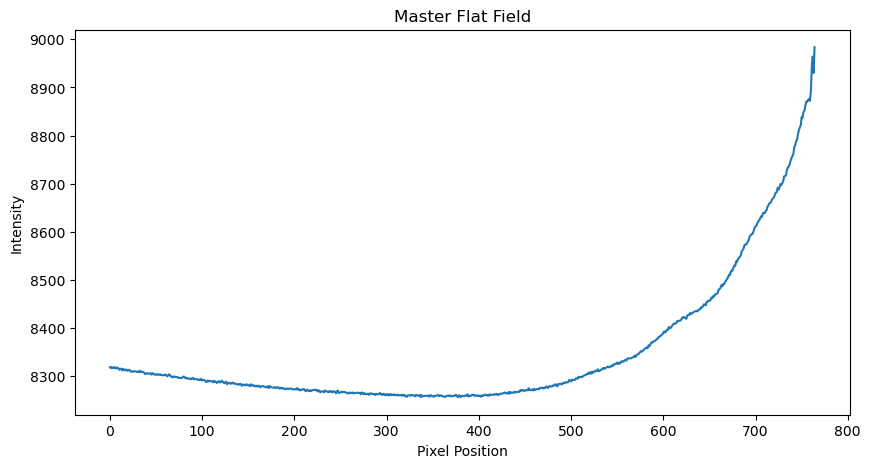

In [87]:
# Step 1: Sum along the y-axis for each mercury frame
master_flatcut_1d= np.median(master_flat_cut, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(master_flatcut_1d)
plt.title("Master Flat Field")
plt.xlabel("Pixel Position")
plt.ylabel("Intensity")
plt.show()

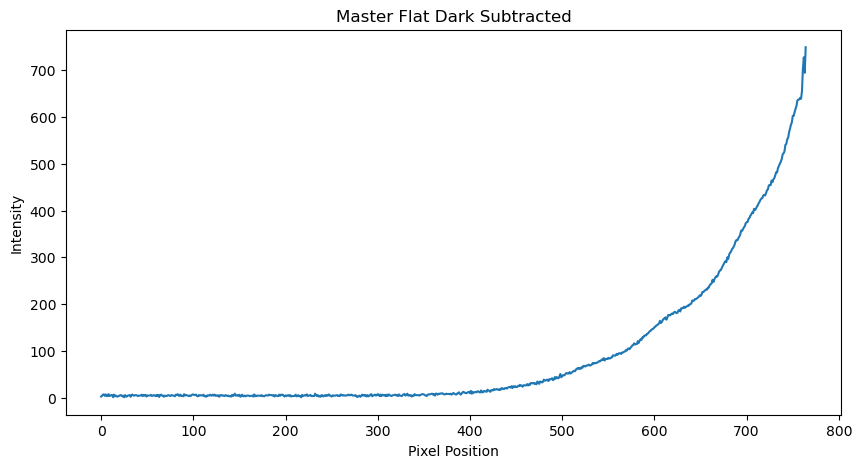

8.166852081639638


In [89]:
# Step 1: Sum along the y-axis for each mercury frame
master_flatdark_1d= np.median(master_flat_dark, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(master_flatdark_1d)
plt.title("Master Flat Dark Subtracted")
plt.xlabel("Pixel Position")
plt.ylabel("Intensity")
#plt.xlim(0, 500)
plt.show()
print(np.max(master_flatdark_1d/np.mean(master_flatdark_1d)))

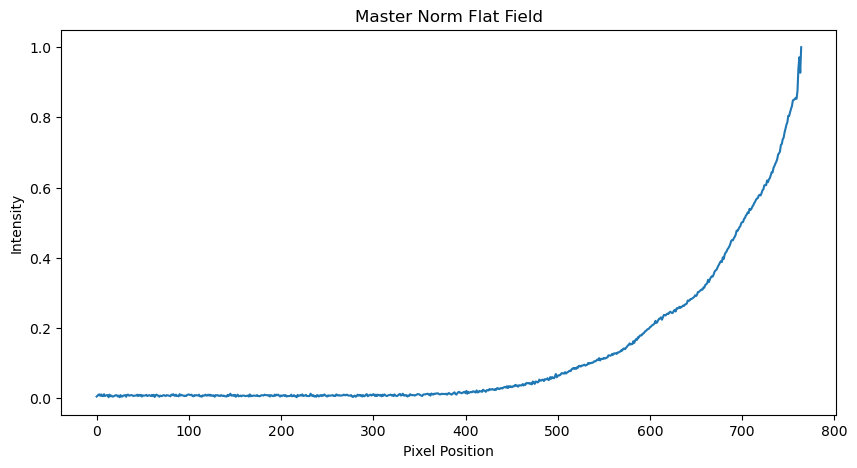

1.0


In [97]:
norm_master_flat = master_flatdark_1d/np.max(master_flatdark_1d)

plt.figure(figsize=(10, 5))
plt.plot(norm_master_flat)
plt.title("Master Norm Flat Field")
plt.xlabel("Pixel Position")
plt.ylabel("Intensity")
#plt.xlim(0, 500)
plt.show()
print(np.max(norm_master_flat))

# Mercury Frames

In [15]:
#Open the mercury frame files and extract the data
raw_mercury=[]

for i in range(2):
    mercury_file = f'{ownerpath}/Lab 3/20tau/mercury_arc_lamp/mercury_light_120s_.0000000{i}.FIT'
    mercury_file_data=fits.open(mercury_file)
    raw_mercury.append(mercury_file_data[0].data)

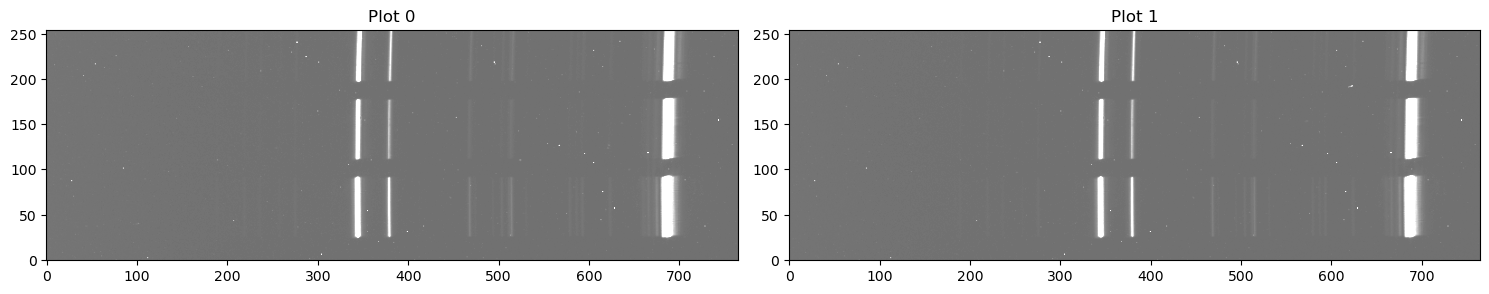

In [16]:
# All mercury frames
fig, axes = plt.subplots(1, 2, figsize=(15, 10))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(2):  # Loop through the 3 indices
    axes[i].imshow(raw_mercury[i],
                   vmin=np.mean(raw_mercury[i]) - np.std(raw_mercury[i]),
                   vmax=np.mean(raw_mercury[i]) + np.std(raw_mercury[i]),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Cropping Mercury frames

In [17]:
# List to hold the cut data of each mercury frame
raw_mercury_cut = []

# Define the y-axis ranges for each frame
y_ranges_raw_hg = [(24, 94), (24, 94)]

# Loop through each corrected frame, cut along y-axis, and extract the data
for i in range(2):
    # Get the full frame data
    mercury_data = raw_mercury[i]

    # Cut the frame data along the y-axis according to the specified range
    hgy_start, hgy_end = y_ranges_raw_hg[i]
    cut_mercury_data = mercury_data[hgy_start:hgy_end, :]

    # Append the cut frame data to the list
    raw_mercury_cut.append(cut_mercury_data)

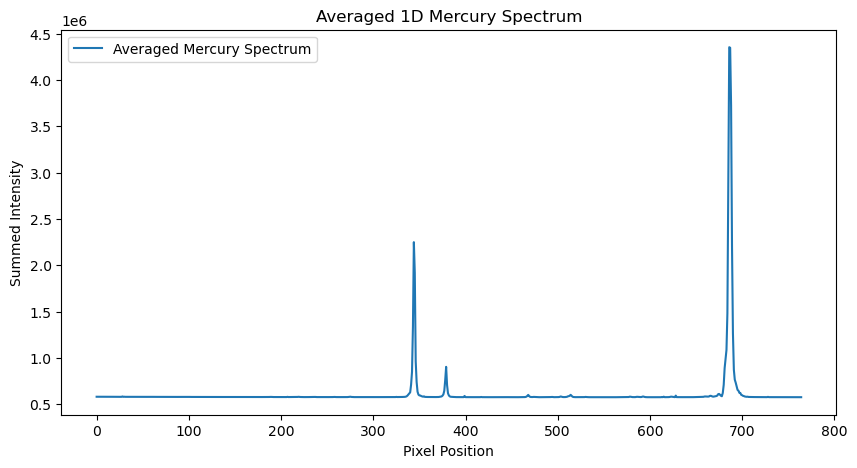

In [18]:
# Step 1: Sum along the y-axis for each mercury frame
summed_mercury = []

for frame in raw_mercury_cut:
    summed_1d = frame.sum(axis=0)  # Sum along the y-axis
    summed_mercury.append(summed_1d)

# Step 2: Average the summed mercury spectra across the frames
average_mercury_spectrum = np.mean(summed_mercury, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(average_mercury_spectrum, label="Averaged Mercury Spectrum")
plt.title("Averaged 1D Mercury Spectrum")
plt.xlabel("Pixel Position")
plt.ylabel("Summed Intensity")
plt.legend()
plt.show()

# Calibrating Pixel Position into Wavelength in nm

In [19]:
#Wavelengths of identified Mercury lines 
#from https://www.newport.com/medias/sys_master/images/images/h55/hfd/8797293281310/Typical-Spectra-of-Spectral-Calib-Lamps.pdf

identified_hg_lines = {
    "Hg 435.86 nm": 435.86,
    "Hg 407.78 nm": 407.78,
    "Hg 404.66 nm": 404.66
}

hg_wavelength=sorted(identified_hg_lines.values())
hg_dict=sorted(identified_hg_lines.keys())

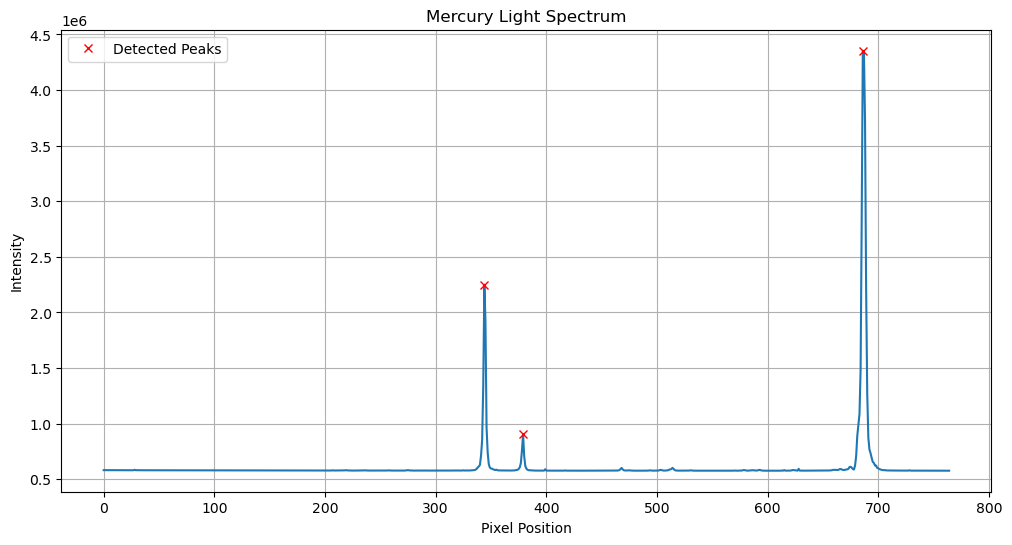

In [20]:
#Finding the peaks of each observed Mercury line

pixel_pos=np.arange(len(average_mercury_spectrum))

peaks, _ = find_peaks(average_mercury_spectrum, prominence=26000)
peak_points= pixel_pos[peaks]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(pixel_pos, average_mercury_spectrum)
plt.plot(peak_points, average_mercury_spectrum[peaks], "x", label='Detected Peaks', color='red')
plt.title('Mercury Light Spectrum')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.legend()
plt.grid()

plt.show()

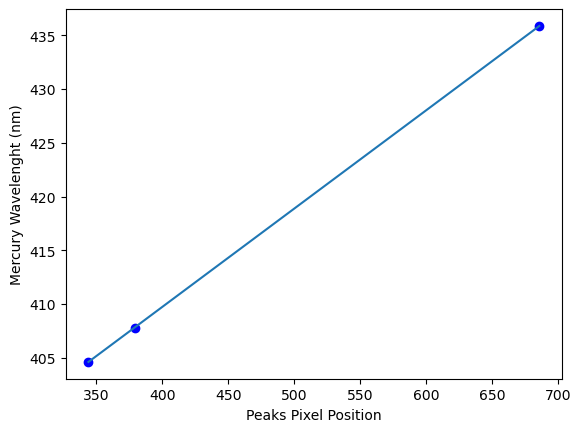

In [21]:
#Finding the pixel to wavelength ratio

w_coef = np.polyfit(peak_points,hg_wavelength,1)
poly1d_w = np.poly1d(w_coef)

plt.plot(peak_points, hg_wavelength, 'bo', peak_points, poly1d_w(peak_points))
plt.xlabel('Peaks Pixel Position')
plt.ylabel('Mercury Wavelenght (nm)')
plt.show()

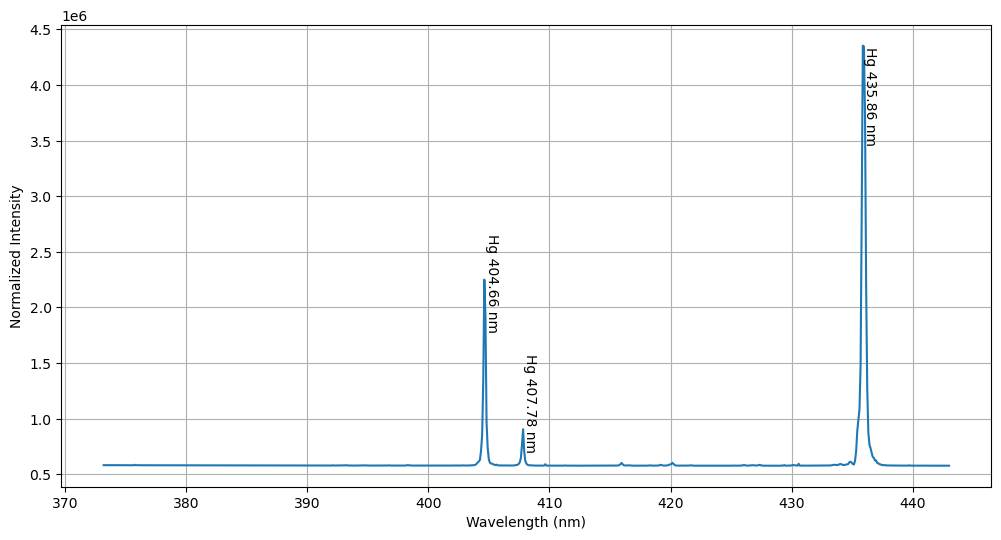

In [22]:
calibrated_wave=(pixel_pos*w_coef[0])+w_coef[1]

plt.figure(figsize=(12, 6))
plt.plot(calibrated_wave, average_mercury_spectrum)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
plt.grid()

# Annotate Neon lines
for i in range(len(hg_wavelength)):
    #plt.axvline(x=n_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(hg_wavelength[i],average_mercury_spectrum[peaks][i]/1.25, hg_dict[i], 
             fontsize=10, rotation=270, color='black', ha='left')

# 20Tau

In [33]:
#Open the 20tau light frame files and extract the data
raw_20tau=[]

for i in range(10):
    if i < 10:
        tau20_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/20tau_light_120s_.0000000{i}.FIT'
    elif i < 20 :
        tau20_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/20tau_light_120s_.000000{i}.FIT'
    tau20_file_data=fits.open(tau20_file)
    raw_20tau.append(tau20_file_data[0].data)

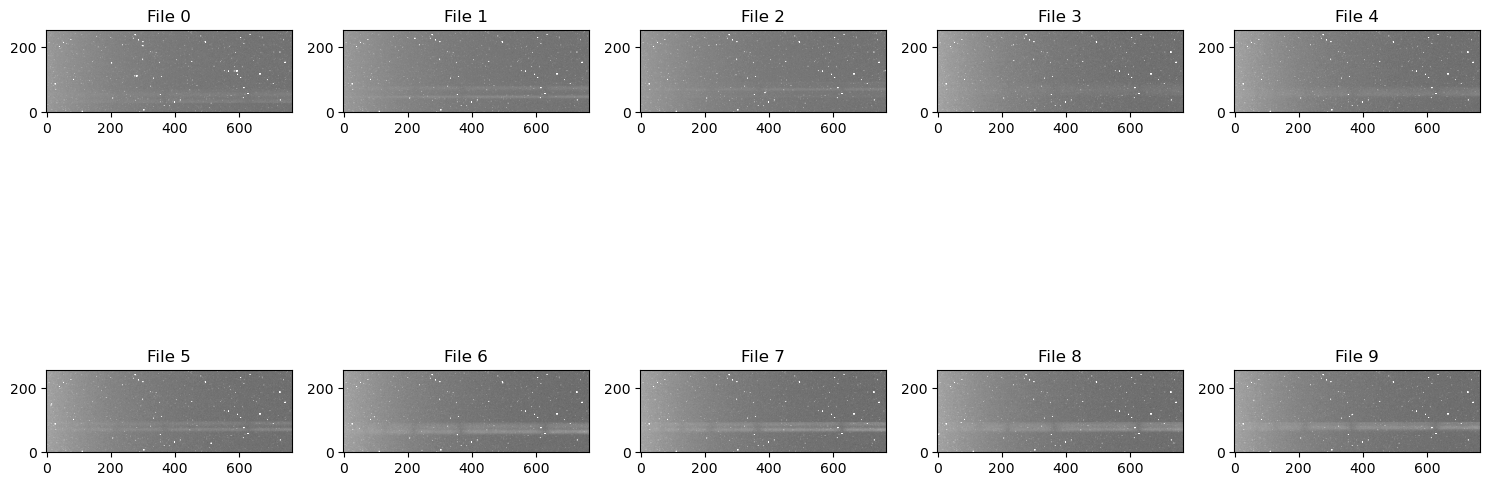

In [34]:
# All light frames of 20 Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 9))  # 2 rows, 5 columns

# Loop through each image and display it on a subplot
for i, ax in enumerate(axes.flat):
    if i < len(raw_20tau):  # Ensure we're not going out of bounds
        ax.imshow(
            raw_20tau[i],
            vmin=np.mean(raw_20tau[i]) - (2 * np.std(raw_20tau[i])),
            vmax=np.mean(raw_20tau[i]) + (2 * np.std(raw_20tau[i])),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"File {i}")  # Title for each subplot
        #ax.axis('off')  # Optionally hide the axis for cleaner look

plt.tight_layout()  # Adjust spacing for a nicer layout
plt.show()

In [35]:
# List to hold the cut data of each corrected 20 Tau frame
raw_20tau_cut = []

# Define the y-axis ranges for each frame
y_20tau_ranges = [(27, 63), (44, 80), (46, 82), (62, 98), (56, 92),
            (60, 96), (59, 95), (60, 96), (61, 97), (61, 97)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
#     tau20_corrected_file = f'{ownerpath}/Lab 3/20tau/corrected_pleiades_light/final_20tau_frame_00{i}.FIT'
#     tau20_corrected_file_data = fits.open(tau20_corrected_file)

#     # Get the full frame data
#     frame_data = tau20_corrected_file_data[0].data

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_20tau_ranges[i]
    cut_frame_data = raw_20tau[i][y_start:y_end, :]

    # Append the cut frame data to the list
    raw_20tau_cut.append(cut_frame_data)

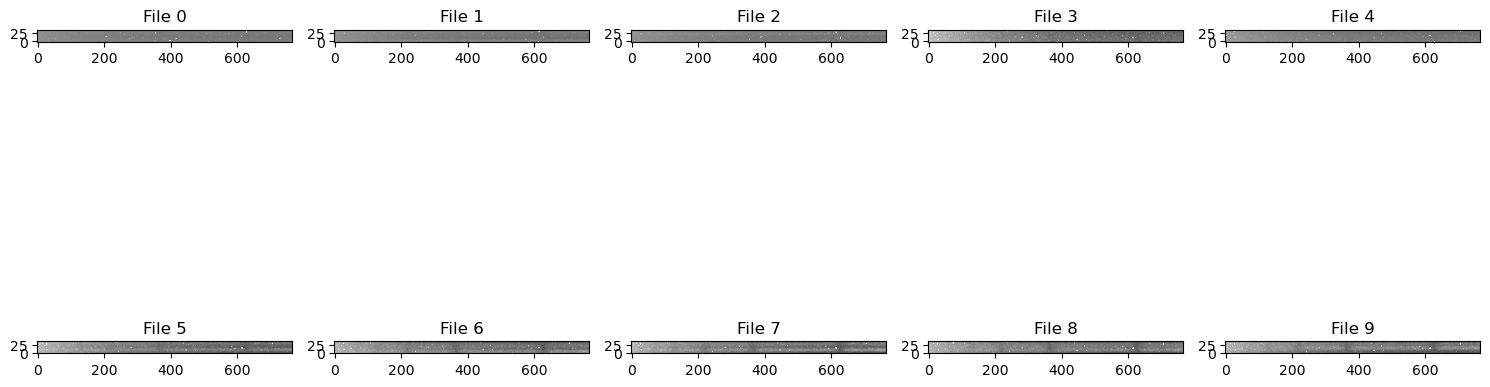

In [36]:
# All light frames of 20 Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 9))  # 2 rows, 5 columns

# Loop through each image and display it on a subplot
for i, ax in enumerate(axes.flat):
    if i < len(raw_20tau_cut):  # Ensure we're not going out of bounds
        ax.imshow(
            raw_20tau_cut[i],
            vmin=np.mean(raw_20tau_cut[i]) - (2 * np.std(raw_20tau_cut[i])),
            vmax=np.mean(raw_20tau_cut[i]) + (2 * np.std(raw_20tau_cut[i])),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"File {i}")  # Title for each subplot
        #ax.axis('off')  # Optionally hide the axis for cleaner look

plt.tight_layout()  # Adjust spacing for a nicer layout
plt.show()

In [38]:
darksubtracted_20tau = []
for i in range(10):
    dark_sub=raw_20tau_cut[i]-darks_20tau_cut[i]
    darksubtracted_20tau.append(dark_sub)

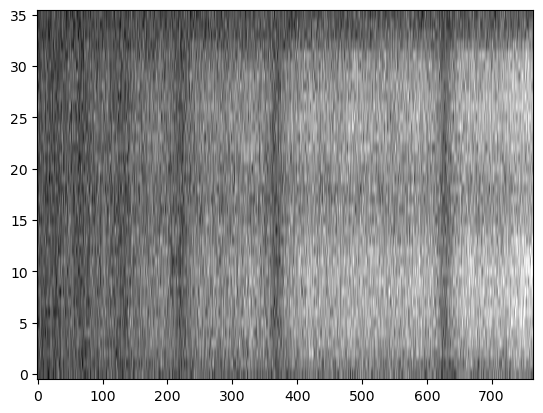

In [42]:
master_20tau = (np.median(darksubtracted_20tau, axis=0))

plt.imshow(master_20tau, cmap='gray',
           vmin=np.mean(master_20tau) - (3 * np.std(master_20tau)),
           vmax=np.mean(master_20tau) + (3 * np.std(master_20tau)), aspect='auto', origin='lower')

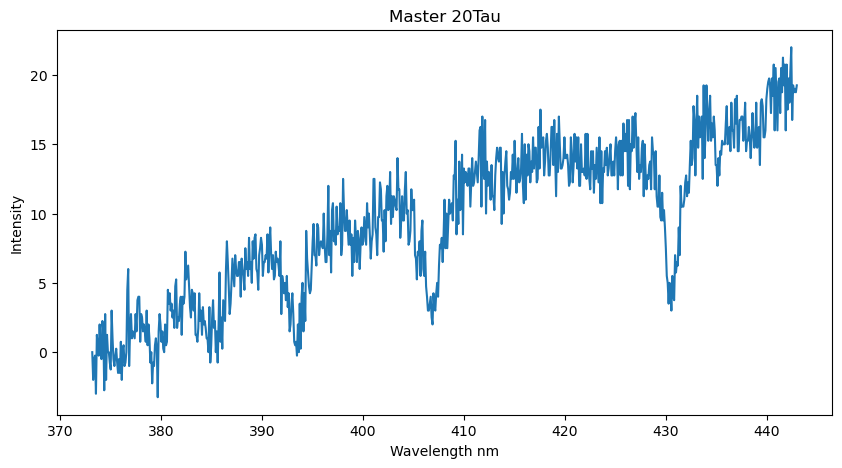

22.0


In [91]:
# Step 1: Sum along the y-axis for each mercury frame
master_20tau_1d= np.median(master_20tau, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_20tau_1d)
plt.title("Master 20Tau")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
plt.show()
print(np.max(master_20tau_1d))

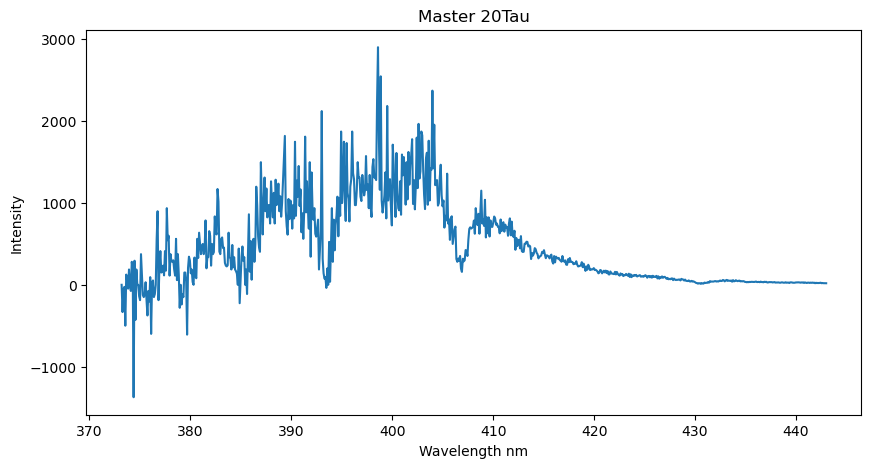

-1372.25


In [95]:
norm_master_20tau = master_20tau_1d/norm_master_flat

plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, norm_master_20tau)
plt.title("Master 20Tau")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
#plt.xlim(500, 750)
#plt.ylim(0, 200)
plt.show()

print(np.min(norm_master_20tau))

# Eta Tau

In [27]:
#Open the etatau light frame files and extract the data
raw_etatau=[]

for i in range(10):
    taueta_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/etatau_light_120s_.0000000{i}.FIT'
    taueta_file_data=fits.open(taueta_file)
    raw_etatau.append(taueta_file_data[0].data)

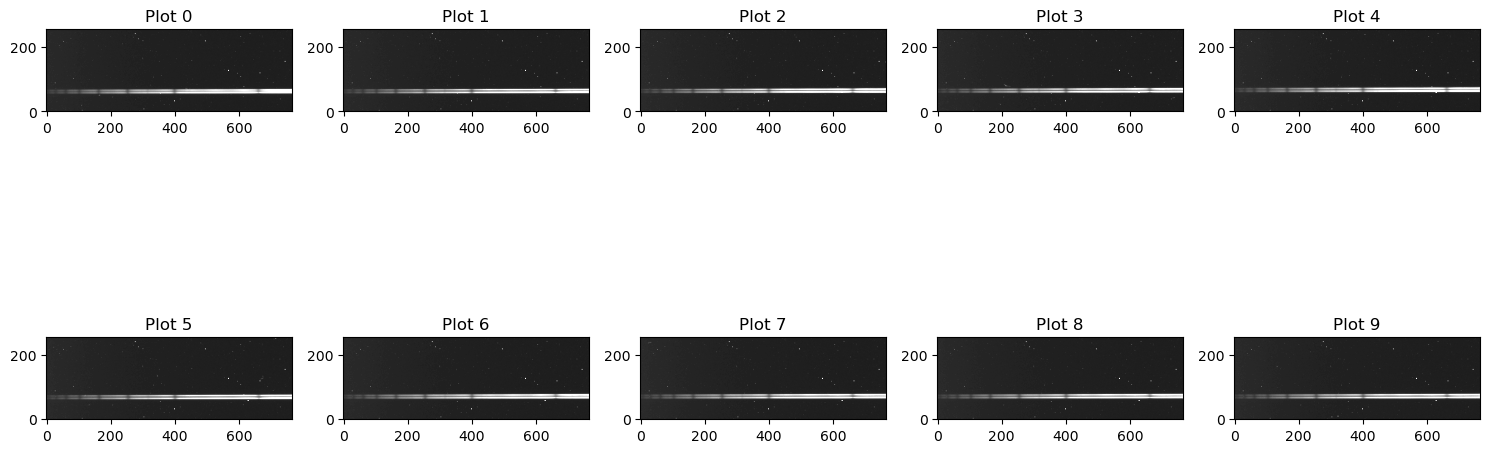

In [28]:
# All 10 light frames of eta Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(10):  # Loop through the 10 indices (0 to 9)
    axes[i].imshow(raw_etatau[i],
                   vmin=np.mean(raw_etatau[i]) - np.std(raw_etatau[i]),
                   vmax=np.mean(raw_etatau[i]) + (5 * np.std(raw_etatau[i])),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')  # Turn off axis for better visualization

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [29]:
# List to hold the cut data of each corrected Eta Tau frame
etatau_cut = []

# Define the y-axis ranges for each frame
y_ranges_eta = [(51, 71), (51, 71), (54, 74), (55, 75), (57, 77),
                (58, 78), (60, 80), (61, 81), (61, 81), (61, 81)]

# Loop through each corrected frame, cut along y-axis, and extract the data
for i in range(10):
    # Get the full frame data
    frame_data = raw_etatau[i]

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_eta[i]
    cut_frame_data = frame_data[y_start:y_end, :]

    # Append the cut frame data to the list
    etatau_cut.append(cut_frame_data)

In [30]:
darksubtracted_etatau = []
for i in range(10):
    dark_sub=etatau_cut[i]-darks_etatau_cut[i]
    darksubtracted_etatau.append(dark_sub)

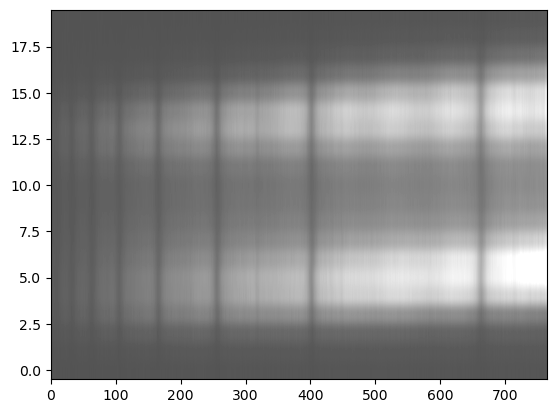

In [32]:
master_etatau = (np.median(darksubtracted_etatau, axis=0))

plt.imshow(master_etatau, cmap='gray',
           vmin=np.mean(master_etatau) - (3 * np.std(master_etatau)),
           vmax=np.mean(master_etatau) + (3 * np.std(master_etatau)), aspect='auto', origin='lower')

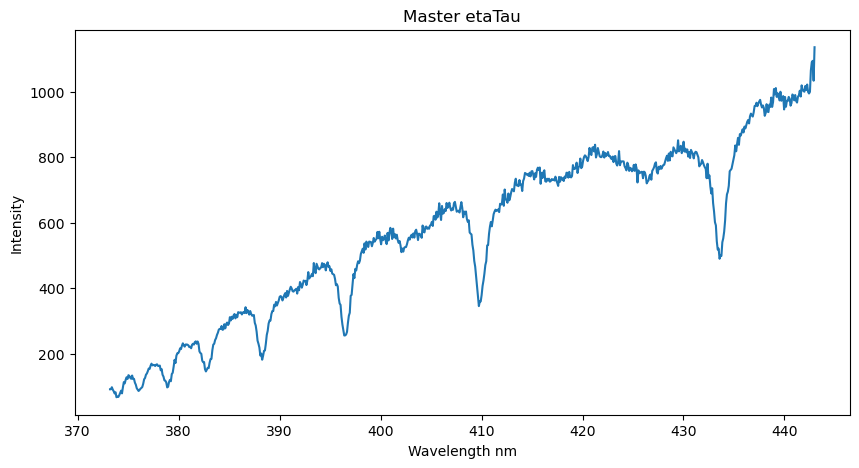

In [93]:
# Step 1: Sum along the y-axis for each mercury frame
master_etatau_1d= np.median(master_etatau, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_etatau_1d)
plt.title("Master etaTau")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
plt.show()

# Q Tau

In [45]:
#Open the qtau light frame files and extract the data
raw_qtau=[]

for i in range(10):
    tauq_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/qtau_light_120s_.0000000{i}.FIT'
    tauq_file_data=fits.open(tauq_file)
    raw_qtau.append(tauq_file_data[0].data)

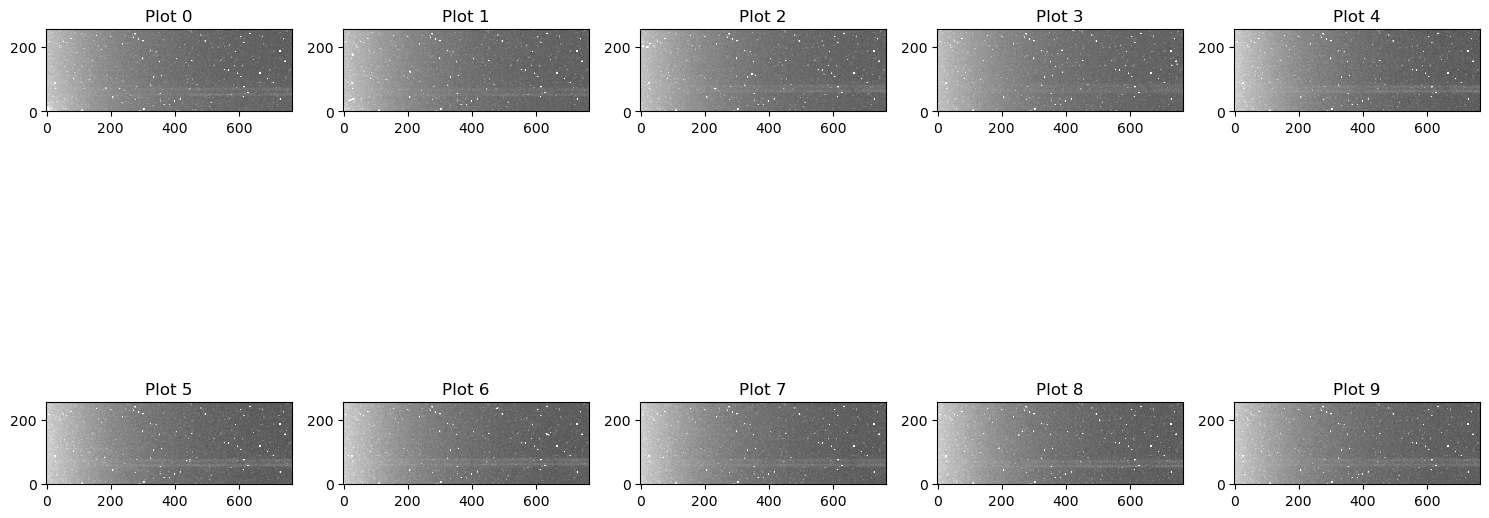

In [46]:
# All 10 light frames of q Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 10))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(10):  # Loop through the 10 indices (0 to 9)
    axes[i].imshow(raw_qtau[i],
                   vmin=np.mean(raw_qtau[i]) - np.std(raw_qtau[i]),
                   vmax=np.mean(raw_qtau[i]) + np.std(raw_qtau[i]),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')  # Turn off axis for better visualization

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [47]:
# List to hold the cut data of each corrected Q Tau frame
qtau_cut = []

# Define the y-axis ranges for each frame
y_ranges_qtau = [(46, 76), (45, 75), (56, 86), (57, 87), (54, 84),
                 (52, 82), (54, 84), (53, 83), (48, 78), (52, 82)]

# Loop through each corrected frame, cut along y-axis, and extract the data
for i in range(10):
    # Get the full frame data
    frame_data = raw_qtau[i]

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_qtau[i]
    cut_frame_data = frame_data[y_start:y_end, :]

    # Append the cut frame data to the list
    qtau_cut.append(cut_frame_data)

In [48]:
darksubtracted_qtau = []
for i in range(10):
    dark_sub=qtau_cut[i]-darks_qtau_cut[i]
    darksubtracted_qtau.append(dark_sub)

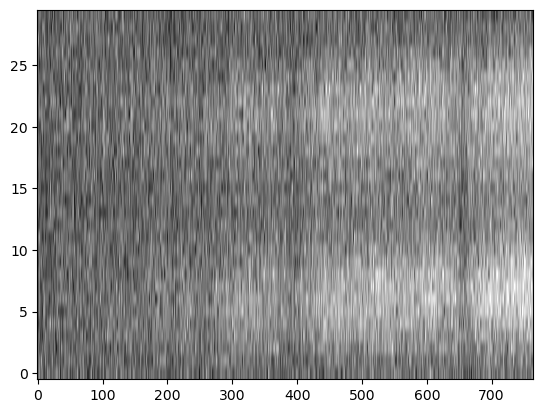

In [50]:
master_qtau = (np.median(darksubtracted_qtau, axis=0))

plt.imshow(master_qtau, cmap='gray',
           vmin=np.mean(master_qtau) - (3 * np.std(master_qtau)),
           vmax=np.mean(master_qtau) + (3 * np.std(master_qtau)), aspect='auto', origin='lower')

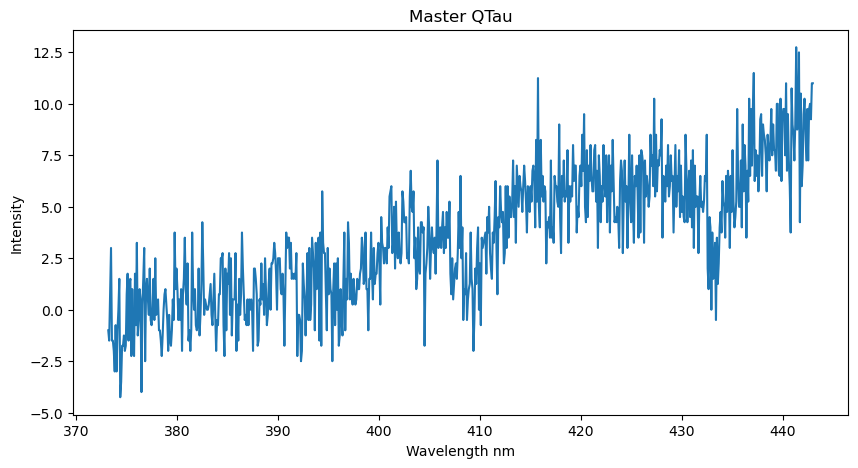

In [94]:
# Step 1: Sum along the y-axis for each mercury frame
master_qtau_1d= np.median(master_qtau, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_qtau_1d)
plt.title("Master QTau")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
plt.show()